In [13]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp

import tqdm

import warnings
warnings.filterwarnings('ignore')

from linear_operator.operators import KroneckerProductLinearOperator, RootLinearOperator
from linear_operator.utils.interpolation import left_interp



In [6]:
from gpytorch import settings
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from gpytorch.module import Module
from gpytorch.variational._variational_strategy import _VariationalStrategy

## Setup scenario

In [7]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
N = 1000
input_dim = 1
train_x = None
train_y = None

# initialise the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
kernel2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
model1 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel1)
model2 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel2)
hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor(.2),
    }, 
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor(.85),
        'covar_module.base_kernel.period_length': torch.tensor(.25)
    }
]
X = torch.linspace(0, 1, N)
Y = torch.empty((N,2))

model1.initialize(**hypers[0])
model1.eval()

torch.manual_seed(55)
with gpytorch.settings.prior_mode(True):
    Y[:,0] = model1(X).sample()

model2.initialize(**hypers[1])
model2.eval()

torch.manual_seed(88)
with gpytorch.settings.prior_mode(True):
    Y[:,1] = model2(X).sample()

g_11 = lambda x: 1 / (1 + np.exp(-x))
g_21 = lambda x: np.exp(x)
g_31 = lambda x: x
g_32 = lambda x: np.exp(x)
A = torch.tensor([
    [1.1, -0.5, 1.1, -.05, -.05, -0.25], # A_1
    [-.05, 0.2, -.05, 1.1, 1.1, .1], # A_2
]).T
A
torch.manual_seed(55)

f_11 = Y @ A[0,:]
f_12 = Y @ A[1,:]
y_1 = torch.normal(f_11, f_12.exp())

torch.manual_seed(55)

f_21 = Y @ A[2,:]
y_2 = dist.Poisson(f_21.exp())()

torch.manual_seed(55)

f_31 = Y @ A[3,:]
y_3 = dist.Poisson(f_31.exp())()

f_41 = Y @ A[4,:]
f_42 = Y @ A[5,:]
y_4 = torch.normal(f_41, f_42.exp())

<AxesSubplot:>

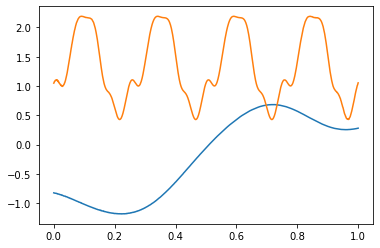

In [8]:
sns.lineplot(X, Y[:,0])
sns.lineplot(X, Y[:,1])

<AxesSubplot:>

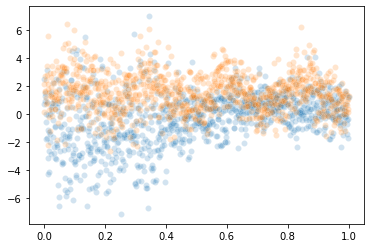

In [9]:
sns.scatterplot(X, y_1, alpha=.2)
# sns.scatterplot(X, y_2, alpha=.2)
sns.scatterplot(X, y_4, alpha=.2)

<AxesSubplot:>

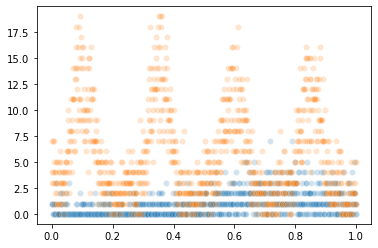

In [10]:
sns.scatterplot(X, y_2, alpha=.2)
sns.scatterplot(X, y_3, alpha=.2)

## Running model

In [15]:
train_x = X
# train_y = torch.stack([y_1, y_2, y_3, y_4], dim=-1)
# train_y = torch.stack([y_1, y_4], dim=-1)
train_y = torch.stack([y_1], dim=-1)
test_x = torch.linspace(0, 1, N).float()#.cuda()

if torch.cuda.is_available():
    train_x, train_y, test_x, = train_x.cuda(), train_y.cuda(), test_x.cuda()

In [ ]:
kernel = gp.kernels.RBF(input_dim=1)


In [ ]:
class VariationalGP(gp.models.VariationalSparseGP):
    
    def __init__(self, X, y, kernel, likelihood, latent_shape=None, num_data=None, whiten=True, jitter=1e-06):
        pass
    
    def forward()

In [448]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_tasks, num_latents=1, name_prefix="lmc_mogp", kernel_type="rbf", kernel_list=None):
        
        self.name_prefix = name_prefix
        
        inducing_points = torch.linspace(0, 1, 500)
        
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-1), batch_shape=torch.Size([num_latents])
        )

        base_variational_strategy = gpytorch.variational.VariationalStrategy(
                self, inducing_points, 
                variational_distribution, # variational distribution over the inducing point values, q(u),
                learn_inducing_locations=True
            )
        
        variational_strategy = LMCVariationalStrategy(
            base_variational_strategy=base_variational_strategy,
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super().__init__(variational_strategy=variational_strategy)
        
        if kernel_type == "matern":
            kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(batch_shape=torch.Size([num_latents])), batch_shape=torch.Size([num_latents]))
        elif kernel_type == "rbfmatern":
            rbf_kernel = gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents]))
            matern_kernel = gpytorch.kernels.MaternKernel(batch_shape=torch.Size([num_latents]))
            kernel = gpytorch.kernels.AdditiveKernel(rbf_kernel, matern_kernel)
        elif kernel_type == "wtf":
            kernel = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), 
                                batch_shape=torch.Size([num_latents])) + \
                        gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
                            batch_shape=torch.Size([num_latents]))
        elif kernel_type == "wtf_try_again":
            kernel = gpytorch.kernels.LCMKernel(
                            [gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()],
                            num_tasks=num_tasks
                        )
        elif kernel_type == "lmc":
            kernel = LMCKernel(kernel_list, batch_shape=torch.Size([num_latents]))
        else:
            kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), 
                                                  batch_shape=torch.Size([num_latents]))
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = kernel

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    @pyro.poutine.scale(scale=1.0/(3000.0))
    def guide(self, x, y):
         # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)

        # Use a plate here to mark conditional independencies
        # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
        
        
    @pyro.poutine.scale(scale=1.0/(3000.0))
    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # Use a plate here to mark conditional independencies
        # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # print(function_samples)
            # Sample from observed distribution
            pyro.sample(
                self.name_prefix + ".y_1",
                dist.Normal(f[...,0], f[...,1].exp()).to_event(1),
                obs=y[...,0]
            )
            
            pyro.sample(
                self.name_prefix + ".y_2",
                dist.Poisson(f[...,2].exp()).to_event(1),
                obs=y[...,1]
            )
            
            pyro.sample(
                self.name_prefix + ".y_3",
                dist.Poisson(f[...,3].exp()).to_event(1),
                obs=y[...,2]
            )
            
            pyro.sample(
                self.name_prefix + ".y_4",
                dist.Normal(f[...,4], f[...,5].exp()).to_event(1),
                obs=y[...,3]
            )

In [450]:
# model = MultitaskGPModel(num_tasks=6, num_latents=2, kernel_type="rbf")
kernel_list = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel()),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())]
model = MultitaskGPModel(num_tasks=6, num_latents=3, kernel_type="lmc", kernel_list=kernel_list)

if torch.cuda.is_available():
    model = model.cuda()

In [451]:
pyro.clear_param_store()

# num_iter = 2000
num_iter = 2000
num_particles = 5

initial_lr = 0.01
gamma = 0.01  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_iter)

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})

elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
# elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    loss = svi.step(train_x, train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

<AxesSubplot:>

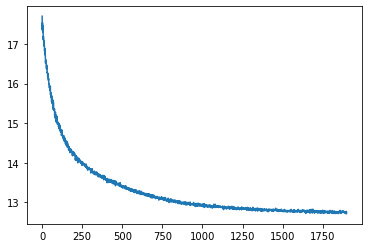

In [452]:
loss_start = 100
sns.lineplot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])

In [453]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [454]:
model.eval()

with torch.no_grad():
    output = model(test_x)

# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000]))
mu_sim = model(test_x)()

lower, mean, upper = percentiles_from_samples(samples.cpu())
train_x, train_y, test_x, test_x_rep = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_x_rep.cpu()

# Draw some simulated y values
y_sim = torch.stack(
    [dist.Normal(mu_sim[:,0].detach(), mu_sim[:,1].detach().exp())(),
     dist.Poisson(mu_sim[:,2].detach().exp())(), 
     dist.Poisson(mu_sim[:,3].detach().exp())(), 
     dist.Normal(mu_sim[:,4].detach(), mu_sim[:,5].detach().exp())()],
    dim=-1
)

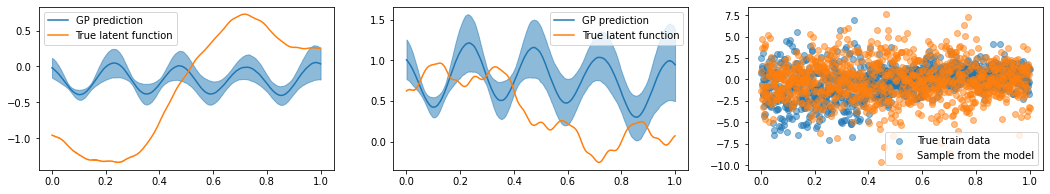

In [455]:
# visualize the result
fig, (*func, samp) = plt.subplots(1, 3, figsize=(18, 3))

for i,j in enumerate(range(2)):
    line, = func[i].plot(test_x, mean[:,j].detach().cpu().numpy(), label='GP prediction')
    func[i].fill_between(
        test_x, lower[:,j].squeeze().detach().cpu().numpy(),
        upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )
    f_plot = f_11 if i == 0 else f_12
    func[i].plot(test_x, f_plot, label='True latent function')
    func[i].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

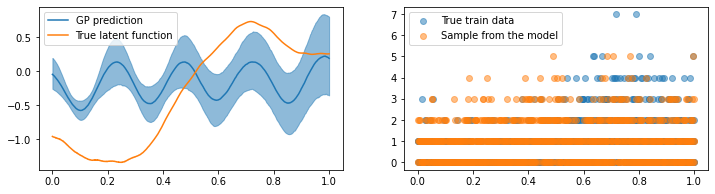

In [456]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,2].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,2].squeeze().detach().cpu().numpy(),
    upper[:,2].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_21, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

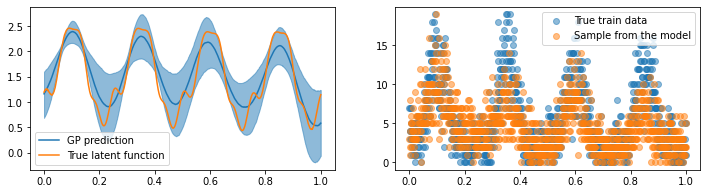

In [457]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,3].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,3].squeeze().detach().cpu().numpy(),
    upper[:,3].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_31, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

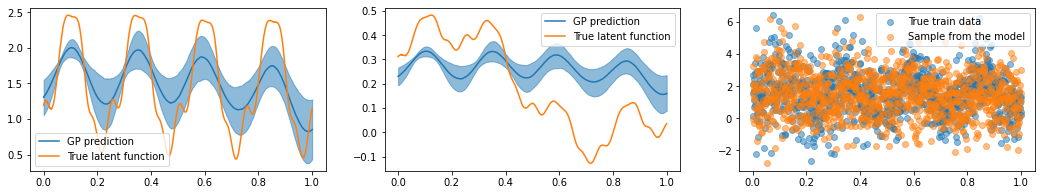

In [458]:
# visualize the result
fig, (*func, samp) = plt.subplots(1, 3, figsize=(18, 3))

for i,j in enumerate(range(4,6)):
    line, = func[i].plot(test_x, mean[:,j].detach().cpu().numpy(), label='GP prediction')
    func[i].fill_between(
        test_x, lower[:,j].squeeze().detach().cpu().numpy(),
        upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )
    f_plot = f_41 if i == 0 else f_42
    func[i].plot(test_x, f_plot, label='True latent function')
    func[i].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,3], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,3].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

## Testing the code

In [437]:
with torch.no_grad():
    latent_dist_draw = model.variational_strategy.latent_dist.rsample()
    latent_dist_draw = latent_dist_draw.cpu()

<AxesSubplot:>

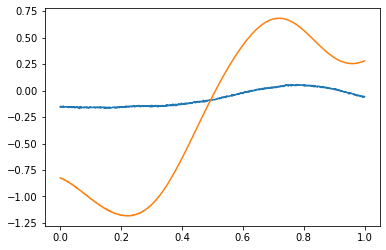

In [438]:
sns.lineplot(np.linspace(0,1,latent_dist_draw.size(-1)), latent_dist_draw[0])
sns.lineplot(np.linspace(0,1,latent_dist_draw.size(-1)), Y[:,0])

<AxesSubplot:>

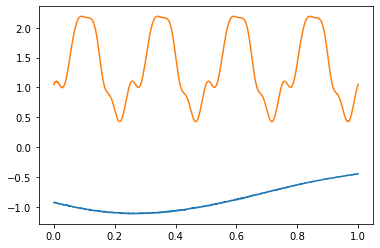

In [439]:
sns.lineplot(np.linspace(0,1,latent_dist_draw.size(-1)), latent_dist_draw[1])
sns.lineplot(np.linspace(0,1,latent_dist_draw.size(-1)), Y[:,1])

In [305]:
model.covar_module.base_kernels[0].base_kernel.lengthscale

tensor([[0.5366]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [306]:
model.covar_module.base_kernels[1].base_kernel.lengthscale

tensor([[0.4790]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [307]:
model.covar_module.base_kernels[1].base_kernel.period_length

tensor([[0.7506]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [308]:
for n, p in model.named_parameters():
    print("name:", n)
    print("parameter:", p)
    print("\n")

name: variational_strategy.lmc_coefficients
parameter: Parameter containing:
tensor([[ 1.0907, -0.5130,  0.9489, -0.0432, -0.0740, -0.1966],
        [-0.0134,  0.1573, -0.0139,  0.8519,  0.8607,  0.0806]],
       device='cuda:0', requires_grad=True)


name: variational_strategy.base_variational_strategy.inducing_points
parameter: Parameter containing:
tensor([[-0.0752],
        [-0.0793],
        [ 0.0260],
        [ 0.0257],
        [ 0.0257],
        [ 0.0261],
        [-0.0772],
        [-0.0773],
        [-0.0774],
        [-0.0775],
        [ 0.0262],
        [ 0.0279],
        [ 0.0263],
        [ 0.1749],
        [-0.0775],
        [ 0.0269],
        [ 0.0284],
        [ 0.0262],
        [ 0.0264],
        [ 0.0264],
        [ 0.0275],
        [ 0.0265],
        [ 0.0273],
        [ 0.0270],
        [ 0.0271],
        [ 0.0284],
        [ 0.0305],
        [ 0.0274],
        [ 0.0279],
        [ 0.0280],
        [ 0.2491],
        [ 0.0273],
        [ 0.0272],
        [ 0.1749],


In [440]:
with torch.no_grad():
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu()

# A_hat = torch.divide(A_hat.T, torch.norm(A_hat, dim=-1)).T

In [441]:
with torch.no_grad():
    latent_dist = model.variational_strategy.latent_dist

In [442]:
def eigen(lmc_coefficients, norm=True, round=3):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    if round is not None:
        V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [443]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

In [446]:
A.T

tensor([[ 1.1000, -0.5000,  1.1000, -0.0500, -0.0500, -0.2500],
        [-0.0500,  0.2000, -0.0500,  1.1000,  1.1000,  0.1000]])

<AxesSubplot:>

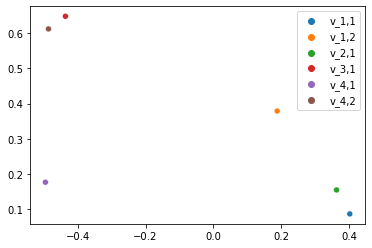

In [444]:
labels = ["v_1,1", "v_1,2", "v_2,1", "v_3,1", "v_4,1", "v_4,2"]
eigval, eigvec = eigen(lmc_coefficients, norm=True)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)

<AxesSubplot:>

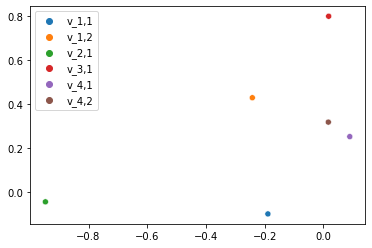

In [445]:
labels = ["v_1,1", "v_1,2", "v_2,1", "v_3,1", "v_4,1", "v_4,2"]
eigval, eigvec = eigen(lmc_coefficients, norm=False)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)

In [359]:
latent_dist.lazy_covariance_matrix

In [367]:
lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))

In [380]:
latent_dist.lazy_covariance_matrix.cpu()

In [382]:
covar = KroneckerProductLinearOperator(latent_dist.lazy_covariance_matrix.cpu(), lmc_factor).sum(-1)

In [450]:
covar.shape

torch.Size([2, 6000])

In [456]:
(covar.T @ covar).shape

torch.Size([6000, 6000])

In [390]:
latent_dist.lazy_covariance_matrix.shape

torch.Size([2, 1000, 1000])

In [387]:
covar[0].shape

torch.Size([6000])

In [215]:
x_multi = torch.randn([500, 3])
init_covar_x = torch.randn([1, 500, 500])
covar_x = torch.randn([2, 1, 500, 500])
x1 = torch.randn([500,1])
x2 = torch.randn([1,500,1])

In [229]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0, 2]))

In [230]:
kernel._

OrderedDict([('raw_outputscale',
              Parameter containing:
              tensor(0., requires_grad=True))])

In [217]:
test = kernel(x_multi).evaluate_kernel()
test.shape

torch.Size([500, 500])

In [287]:
kernel = LMCKernel(
    [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3, active_dims=[0, 7000])),
     gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims=[0, 2]))],
    batch_shape=2
)

In [288]:
test = kernel(x).evaluate_kernel()
test.shape

params: {'last_dim_is_batch': False}
init_x_shape: torch.Size([500, 1])
x_shape: torch.Size([1, 500, 1])
init_covar_x.shape: torch.Size([1, 500, 500])
kernel: ScaleKernel(
  (base_kernel): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
    (distance_module): Distance()
  )
  (raw_outputscale_constraint): Positive()
)
covar_x.shape: torch.Size([2, 500, 500])


torch.Size([2, 500, 500])

In [244]:
kernel_list = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0, 2])),
     gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())]

kernel = torch.nn.ModuleList(
    kernel_list
)

In [246]:
kernel[0](x_multi).evaluate_kernel().shape

torch.Size([500, 500])

In [398]:
num_latents=2
num_tasks=6
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), 
                                batch_shape=torch.Size([num_latents])) + \
                        gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
                            batch_shape=torch.Size([num_latents]))

# torch.Size([2, 1000, 1000]) # CORRECT!                        
# kernel(train_x).shape

torch.Size([2, 1000, 1000])

In [396]:
kernel = gpytorch.kernels.LCMKernel(
                            [gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()],
                            num_tasks=num_tasks
                        )

# torch.Size([6000, 6000]) # WRONG!
# kernel(train_x).shape

In [642]:
kernel_list = torch.nn.ModuleList([gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()])

In [643]:
kernel1 = kernel_list[0](train_x.cpu(), train_x.cpu()).evaluate()
kernel2 = kernel_list[1](train_x.cpu()).evaluate()

In [671]:
kernel1.shape

torch.Size([1000, 1000])

In [680]:
torch.concat([kernel1, kernel2]).shape

torch.Size([2000, 1000])

In [669]:
torch.vstack([kernel1, kernel2]).shape

torch.Size([2000, 1000])

In [652]:
torch.vstack([kernel1, kernel2], dim=0).shape

torch.Size([2, 1000, 1000])

In [645]:
kernel1.shape

torch.Size([1000, 1000])

In [424]:
torch.stack([kernel1, kernel2]).shape

torch.Size([2, 1000, 1000])

In [459]:
kernel_list

ModuleList(
  (0): RBFKernel(
    (raw_lengthscale_constraint): Positive()
    (distance_module): Distance()
  )
  (1): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
    (distance_module): Distance()
  )
)

In [482]:
gpytorch.kernels.kernel.Kernel

gpytorch.kernels.kernel.Kernel

In [504]:
torch.empty(len(kernel_list),len(train_x)).shape

torch.Size([2, 1000])

In [549]:
torch.stack([covar_x, covar_x, covar_x])

tensor([[-9.4344e+17,  4.5604e-41],
        [-9.4344e+17,  4.5604e-41],
        [-9.4344e+17,  4.5604e-41]])

In [629]:
kernel_list = [gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()]

kernel = LMCKernel(kernel_list, batch_shape=torch.Size([num_latents]))

In [630]:
kernel(train_x.cpu()).evaluate_kernel().shape

torch.Size([2, 1000, 1000])


torch.Size([2, 1000, 1000])